In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import random

from dotenv import load_dotenv, find_dotenv
from pathlib import Path

from torch.utils.data import DataLoader, random_split
from tqdm.notebook import tqdm

from src.data import FimacDataset
from src.models import load_model

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = 'cpu'

# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()
project_dir = Path(dotenv_path).parent

# load up the entries as environment variables
load_dotenv(dotenv_path)

True

In [3]:
model_fpath = project_dir/'models/genial-wood-25__TestNet.pth'
net = load_model(model_fpath).to(device)
net.eval()
net

TestNet(
  (conv1): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (fc1): Linear(in_features=1048576, out_features=128, bias=True)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

In [4]:
dataset = FimacDataset(project_dir/'data/interim/renders.hdf5')

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# split train into train and validation
train_val_split = .8
train_size = int(len(dataset) * train_val_split)
train_data, val_data = random_split(
    dataset,
    (train_size, len(dataset) - train_size),
)

In [7]:
ys = list()
y_hats = list()

for X, y in tqdm(DataLoader(val_data, shuffle=True, batch_size=32)):
    y_hat = net(X)
    
    ys += list(y.numpy())
    y_hats += list(y_hat.squeeze().detach().numpy())

df = pd.DataFrame([ys, y_hats]).T
df.columns = ['gt', 'pred']

df['gt'] = df['gt'].astype(int)
df['pred_int'] = (df['pred'] + 0.5).astype(int)
df['err'] = (df['pred'] - df['gt']).abs()
df['hit'] = df['pred_int'] == df['gt']

df.head()

  0%|          | 0/505 [00:00<?, ?it/s]

,gt,pred,pred_int,err
0,23,22.490866,22,0.509134
1,14,14.037080,14,0.037080
2,43,42.456673,42,0.543327
3,32,32.722424,33,0.722424
4,18,17.588490,18,0.411510


In [8]:
acc = df['hit'].mean()
mean_err = (df['pred_int'] - df['gt']).abs().mean()

print(f"Mean error \t= {mean_err:.2f}")
print(f"Accuracy \t= {100*acc:.2f} %")

Mean error 	= 1.20
Accuracy 	= 28.47 %


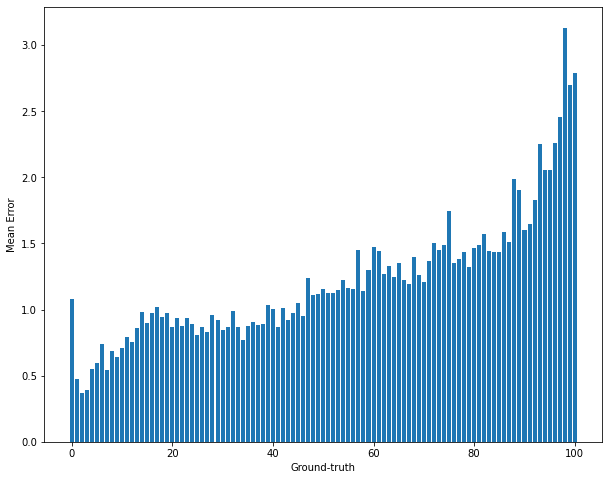

In [9]:
err = df.groupby('gt')['err'].agg((np.mean, np.std, np.median))
plt.bar(err.index, err['mean'])
plt.gcf().set_size_inches(10,8)
plt.ylabel('Mean Error')
plt.xlabel('Ground-truth')
plt.show()

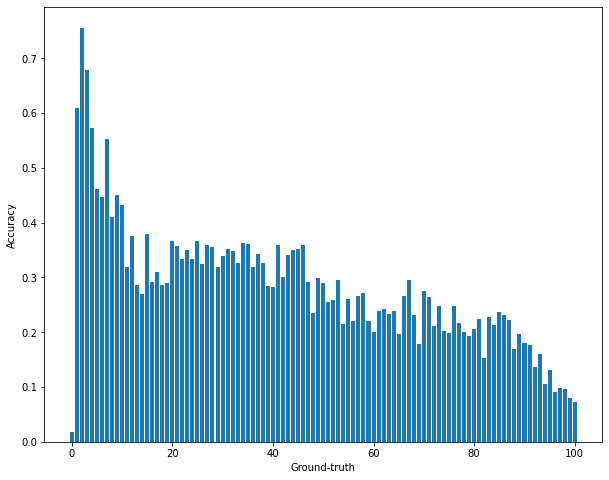

In [14]:
split_acc = df.groupby('gt')['hit'].mean()
plt.bar(split_acc.index, split_acc.values)
plt.gcf().set_size_inches(10,8)
plt.ylabel('Accuracy')
plt.xlabel('Ground-truth')
plt.show()